# Machine Learning Pipeline - Data Analysis

Implementation of each of the steps in the Machine Learning Pipeline. 

1. **Data Analysis**
2. Feature Engineering
3. Feature Selection
4. Model Training
5. Obtaining Predictions / Scoring

Plane Crash Dataset available on [Kaggle.com](https://www.kaggle.com/datasets/kamilkarczmarczyk/plane-crash-dataset-03042023). See below for more details.

===================================================================================================

Data description:
- Date: Date of accident, in the format - January 01, 2001
- Time: Local time, in 24 hr. format unless otherwise specified
- Airline/Op: Airline or operator of the aircraft
- Flight #: Flight number assigned by the aircraft operator
- Route: Complete or partial route flown prior to the accident
- AC Type: Aircraft type
- Reg: ICAO registration of the aircraft
- cn / ln: Construction or serial number / Line or fuselage number
- Aboard: Total aboard (passengers / crew)
- Fatalities: Total fatalities aboard (passengers / crew)
- Ground: Total killed on the ground
- Summary: Brief description of the accident and cause if known

# Data Analysis

In [1]:
# ! python -m spacy download en_core_web_sm

In [2]:
# to handle datasets
import pandas as pd
import numpy as np
import datetime as dt

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for the yeo-johnson transformation
import scipy.stats as stats

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import spacy
from typing import Union
import logging
import itertools

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

%matplotlib inline

In [3]:
nlp = spacy.load("en_core_web_sm")
logging.getLogger().setLevel(logging.INFO)

In [4]:
# load dataset
raw_data = pd.read_csv("data/raw_data.csv", sep=";")

# rows and columns of the data
print(raw_data.shape)

# visualise the dataset
raw_data.head()

(5028, 17)


,Date,Time:,Location:,AC Type:,Operator:,Route:,cn / ln:,Flight #:,Is_military,Military country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground:,Registration:,Summary:
0,18.03.1946,NaN,"Between Chungking and Shanghai, China",NaN,China National Aviation Corporation,Chunking - Shanghai,NaN,NaN,No,NaN,?,?,?,?,NaN,139,Disappeared while en route. Plane never located.
1,09.11.1944,NaN,"Seljord, Norway",NaN,Military - U.S. Army Air Corps,NaN,NaN,NaN,Yes,U.S. Army Air Corps,?,?,?,?,NaN,42-52196,NaN
2,09.05.1989,NaN,"Near Tainjin, China",Bell 412,Aero Asahi,NaN,33070,NaN,No,NaN,?,?,10,?,0.0000,JA9596,NaN
3,20.02.1992,NaN,En route from Argentina to California,Boeing B-747,Aerolineas Argentinas,NaN,NaN,386,No,NaN,?,?,1,?,0.0000,NaN,A passenger died of cholera while en route.
4,13.03.1954,NaN,"Dien Bien Phu, South Vietnam",C-46,Aigle Azur,NaN,NaN,NaN,No,NaN,?,?,?,?,NaN,NaN,Shot down.


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5028 entries, 0 to 5027
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   5028 non-null   object 
 1   Time:                  3482 non-null   object 
 2   Location:              5023 non-null   object 
 3   AC        Type:        5014 non-null   object 
 4   Operator:              5018 non-null   object 
 5   Route:                 4264 non-null   object 
 6   cn / ln:               4358 non-null   object 
 7   Flight #:              1338 non-null   object 
 8   Is_military            5018 non-null   object 
 9   Military country       766 non-null    object 
 10  Aboard_all             5028 non-null   object 
 11  Aboard_passengers      5028 non-null   object 
 12  Fatalities_all         5028 non-null   object 
 13  Fatalities_passengers  5028 non-null   object 
 14  Ground:                4984 non-null   float64
 15  Regi

In [6]:
class DataSchema:
    DATE = "Date"
    TIME = "Time:"
    LOCATION = "Location:"
    AC_TYPE = "AC        Type:"
    OPERATOR = "Operator:"
    ROUTE = "Route:"
    CN_LN = "cn / ln:"
    FLIGHT_N = "Flight #:"
    IS_MILITARY = "Is_military"
    MILITARY_COUNTRY = "Military country"
    ABOARD_ALL = "Aboard_all"
    ABOARD_PASSENGERS = "Aboard_passengers"
    FATALITIES_ALL = "Fatalities_all"
    FATALITIES_PASSENGERS = "Fatalities_passengers"
    GROUND = "Ground:"
    REGISTRATION = "Registration:"
    SUMMARY = "Summary:"
    YEAR = "Year"
    MONTH = "Month"
    HOUR = "Hour"
    ROUTES_N = "Routes_Number"

In [7]:
redundant_columns = []
data = raw_data.copy()

In [8]:
data = data.replace("?", np.nan)
data.head()

,Date,Time:,Location:,AC Type:,Operator:,Route:,cn / ln:,Flight #:,Is_military,Military country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground:,Registration:,Summary:
0,18.03.1946,NaN,"Between Chungking and Shanghai, China",NaN,China National Aviation Corporation,Chunking - Shanghai,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,139,Disappeared while en route. Plane never located.
1,09.11.1944,NaN,"Seljord, Norway",NaN,Military - U.S. Army Air Corps,NaN,NaN,NaN,Yes,U.S. Army Air Corps,NaN,NaN,NaN,NaN,NaN,42-52196,NaN
2,09.05.1989,NaN,"Near Tainjin, China",Bell 412,Aero Asahi,NaN,33070,NaN,No,NaN,NaN,NaN,10,NaN,0.0000,JA9596,NaN
3,20.02.1992,NaN,En route from Argentina to California,Boeing B-747,Aerolineas Argentinas,NaN,NaN,386,No,NaN,NaN,NaN,1,NaN,0.0000,NaN,A passenger died of cholera while en route.
4,13.03.1954,NaN,"Dien Bien Phu, South Vietnam",C-46,Aigle Azur,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shot down.


In [9]:
def get_pct_missing_and_unique(col: str, alias: str = None) -> None:
    alias = alias if alias else col
    print(data[col].isna().value_counts())
    print(f"\033[31m{alias} field has {data[col].isna().sum()/data.shape[0]:.2%} missing values\033[0m")
    print(f"\033[32m{alias} field has {data[col].nunique()/data.shape[0]:.2%} unique values\033[0m")

## Missing values

In [10]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

data[vars_with_na].isnull().mean().sort_values(ascending=False)

Military country        0.8477
Flight #:               0.7339
Time:                   0.3075
Route:                  0.1519
cn / ln:                0.1333
Registration:           0.0547
Fatalities_passengers   0.0467
Aboard_passengers       0.0440
Summary:                0.0117
Ground:                 0.0088
Aboard_all              0.0034
AC        Type:         0.0028
Operator:               0.0020
Is_military             0.0020
Fatalities_all          0.0016
Location:               0.0010
dtype: float64

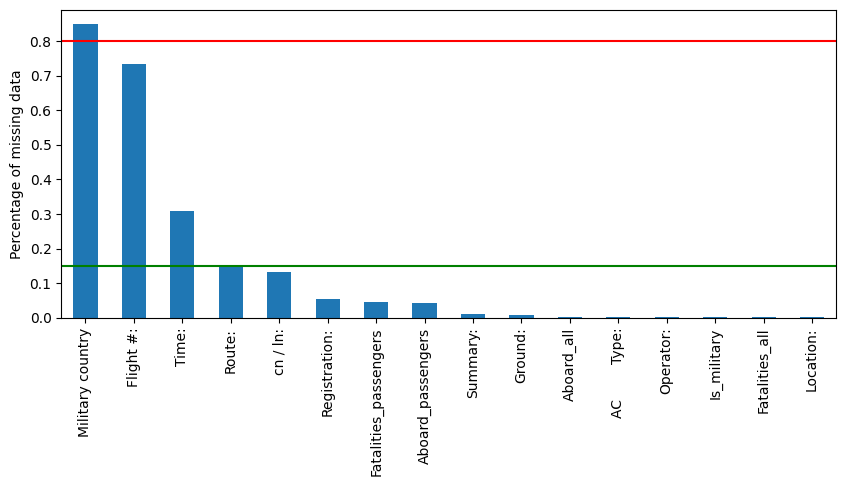

In [11]:
# plot

data[vars_with_na].isnull().mean().sort_values(
    ascending=False).plot.bar(figsize=(10, 4))
plt.ylabel('Percentage of missing data')
plt.axhline(y=0.80, color='r', linestyle='-')
plt.axhline(y=0.15, color='g', linestyle='-')

plt.show()

## Date: extract year and month

In [12]:
# check missing values
get_pct_missing_and_unique(DataSchema.DATE)

Date
False    5028
Name: count, dtype: int64
Date field has 0.00% missing values
Date field has 91.41% unique values


In [13]:
# extract year and month from date into separate columns
data[DataSchema.YEAR] = pd.to_datetime(data[DataSchema.DATE]).dt.year
data[DataSchema.MONTH] = pd.to_datetime(data[DataSchema.DATE]).dt.month
redundant_columns.append(DataSchema.DATE)

## Time: extract hour

In [14]:
# check missing values
get_pct_missing_and_unique(DataSchema.TIME, "Time")

Time:
False    3482
True     1546
Name: count, dtype: int64
Time field has 30.75% missing values
Time field has 21.16% unique values


In [15]:
# extract hour from time if time is not NaN else assign time to 25
# TODO change hour 25 for eg. with most frequent value for same year, month, operator
data[DataSchema.HOUR] = data[DataSchema.TIME].apply(
    lambda x: dt.datetime.strptime(x, '%H:%M:%S').hour if x is not np.nan else 25)
redundant_columns.append(DataSchema.TIME)

## Location: check number of unique values, extract state

In [16]:
get_pct_missing_and_unique(DataSchema.LOCATION, "Location")

Location:
False    5023
True        5
Name: count, dtype: int64
Location field has 0.10% missing values
Location field has 82.30% unique values


In [17]:
data[data[DataSchema.LOCATION].isna()]

,Date,Time:,Location:,AC Type:,Operator:,Route:,cn / ln:,Flight #:,Is_military,Military country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground:,Registration:,Summary:,Year,Month,Hour
306,31.12.1934,NaN,NaN,Tupolev ANT-9,Aeroflot,NaN,NaN,NaN,No,NaN,10,8,10,8,0.0000,NaN,Crashed under unknown circumstances.,1934,12,25
1652,20.01.1977,NaN,NaN,Bristol 170 Freighter 31M,North Canada Air,NaN,13253,NaN,No,NaN,2,0,1,0,0.0000,C-FWAD,The cargo plane stalled nearly vertical and cr...,1977,1,25
2720,27.11.1947,NaN,NaN,Douglas DC-3,China National Aviation Corporation,NaN,NaN,NaN,No,NaN,3,0,2,0,0.0000,NaN,The cargo plane was shot down by communist ant...,1947,11,25
3446,21.08.1942,NaN,NaN,Siebel Si-204,Deutsche Lufthansa,NaN,NaN,NaN,No,NaN,4,2,4,2,0.0000,NaN,"Lufthansa chairman, Von Gablenz killed.",1942,8,25
4278,20.06.1937,NaN,NaN,Travel Air 6000,ENTA,San José San Isidro de El General,NaN,NaN,No,NaN,6,5,6,5,NaN,TI-3,Hit trees and crashed in an isolated area loca...,1937,6,25


In [18]:
def get_locations(text: str) -> Union[None, str]:    
    if text is np.nan:
        return text
    locations = [] 
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_=="GPE":
            locations.append(ent.text)
    return locations[-1] if locations else text

data[DataSchema.LOCATION] = data[DataSchema.LOCATION].apply(lambda x: get_locations(x))

In [19]:
print(f"\033[31mLocation field after parsing for country has {data[DataSchema.LOCATION].nunique()/data.shape[0]:.2%} unique values\033[0m")

Location field after parsing for country has 11.61% unique values


## AC Type: check for missing values

In [20]:
get_pct_missing_and_unique(DataSchema.AC_TYPE, "Aircraft Type")

AC        Type:
False    5014
True       14
Name: count, dtype: int64
Aircraft Type field has 0.28% missing values
Aircraft Type field has 48.19% unique values


In [21]:
data[data[DataSchema.AC_TYPE].isna()]

,Date,Time:,Location:,AC Type:,Operator:,Route:,cn / ln:,Flight #:,Is_military,Military country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground:,Registration:,Summary:,Year,Month,Hour
0,18.03.1946,NaN,China,NaN,China National Aviation Corporation,Chunking - Shanghai,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,139,Disappeared while en route. Plane never located.,1946,3,25
1,09.11.1944,NaN,Norway,NaN,Military - U.S. Army Air Corps,NaN,NaN,NaN,Yes,U.S. Army Air Corps,NaN,NaN,NaN,NaN,NaN,42-52196,NaN,1944,11,25
22,08.11.1943,NaN,India,NaN,Military - Indian Air Force,NaN,NaN,NaN,Yes,Indian Air Force,1,NaN,1,NaN,37.0000,NaN,Crashed into a village.,1943,11,25
924,08.04.1946,NaN,China,NaN,NaN,Shensi - Yenan,NaN,NaN,NaN,NaN,14,11,14,11,0.0000,NaN,NaN,1946,4,25
1284,08.04.1922,NaN,China,NaN,NaN,Test,NaN,NaN,NaN,NaN,17,0,17,0,0.0000,NaN,Aboard were all workers taking part in a fligh...,1922,4,25
1616,29.06.1945,NaN,India,NaN,Military - Royal Indian Air Force,NaN,NaN,NaN,Yes,Royal Indian Air Force,2,NaN,2,NaN,36.0000,NaN,Crashed into a village exploding and destoying...,1945,6,25
1623,08.08.1951,21:00:00,Australia,NaN,Trans Australia Airlines,Hobart Melbourne,13083,NaN,No,NaN,2,0,2,0,0.0000,VH-TAT,Cargo plane. Loss of lateral control during a ...,1951,8,21
1862,17.03.1946,NaN,China,NaN,Military - Chinese Air Force,Shanghai - Nanking,NaN,NaN,Yes,Chinese Air Force,20,NaN,20,NaN,0.0000,NaN,Crashed into mountainous terrain in low visibi...,1946,3,25
1863,11.02.1996,NaN,Afghanistan,NaN,Military - Taliban Militia,NaN,NaN,NaN,Yes,Taliban Militia,20,NaN,20,NaN,0.0000,NaN,The helicopter was shot down.,1996,2,25
2623,11.12.1941,NaN,Florida,NaN,Pan American Airways,NaN,NaN,NaN,No,NaN,3,NaN,3,NaN,0.0000,NC21V,NaN,1941,12,25


In [22]:
# TODO group Aircraft types

## Operator

In [23]:
get_pct_missing_and_unique(DataSchema.OPERATOR, "Operator")

Operator:
False    5018
True       10
Name: count, dtype: int64
Operator field has 0.20% missing values
Operator field has 45.07% unique values


In [24]:
data[data[DataSchema.OPERATOR].isna()]

,Date,Time:,Location:,AC Type:,Operator:,Route:,cn / ln:,Flight #:,Is_military,Military country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground:,Registration:,Summary:,Year,Month,Hour
158,07.09.1909,NaN,France,Wright Byplane,NaN,Air show,NaN,NaN,NaN,NaN,1,0,1,0,0.0000,SC1,Eugene Lefebvre was the first pilot to ever be...,1909,9,25
728,04.07.1943,23:00:00,Gibraltar,Consolidated Liberator B24 C,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,12,NaN,0.0000,A-L-523,"The flight, bound for London, crashed into the...",1943,7,23
924,08.04.1946,NaN,China,NaN,NaN,Shensi - Yenan,NaN,NaN,NaN,NaN,14,11,14,11,0.0000,NaN,NaN,1946,4,25
1145,17.06.1917,NaN,England,Zepplin L-48 (air ship),NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,14,NaN,0.0000,L-48,Shot down by aircraft.,1917,6,25
1189,02.09.1963,NaN,Northeast Laos,Curtiss C-46 Commando,NaN,NaN,NaN,NaN,NaN,NaN,16,13,15,12,NaN,NaN,Refugee flight.,1963,9,25
1284,08.04.1922,NaN,China,NaN,NaN,Test,NaN,NaN,NaN,NaN,17,0,17,0,0.0000,NaN,Aboard were all workers taking part in a fligh...,1922,4,25
2847,26.12.2011,05:54:00,Florida,Bell 206B,NaN,"Jacksonville, FL - Gainsville, FL",2636,NaN,NaN,NaN,3,2,3,2,0.0000,N5016M,The on-demand air taxi was on a flight to proc...,2011,12,5
2892,04.07.1922,NaN,Germany,LVG C VI,NaN,Hamburg - Berlin,NaN,NaN,NaN,NaN,3,2,2,1,0.0000,NaN,The passenger/mail plane lost it's engine whil...,1922,7,25
3932,26.09.1926,NaN,New York,Sikorsky S-25,NaN,New York - Paris,NaN,NaN,NaN,NaN,5,4,2,2,0.0000,NaN,Too much weight caused the landing gear to col...,1926,9,25
4847,29.05.1935,NaN,Honduras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,6,NaN,0.0000,NaN,Crashed into the Ulua River.,1935,5,25


In [25]:
data[DataSchema.OPERATOR]

0       China National Aviation Corporation
1            Military - U.S. Army Air Corps
2                                Aero Asahi
3                     Aerolineas Argentinas
4                                Aigle Azur
                       ...                 
5023       Military - Royal Saudi Air Force
5024                American Flyers Airline
5025                                Bek Air
5026         Pakistan International Airline
5027               KLM Royal Dutch Airlines
Name: Operator:, Length: 5028, dtype: object

In [26]:
def get_operatos_list(text: str) -> Union[None, list]:
    if text is np.nan:
        return text
    if "test" in text.lower():
        return text
    operators = []
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == "ORG":
            operators.append(ent.text)
    return operators[-1] if operators else text

# test
# x = [np.nan, "Military - U.S. Army Air Corps", "Test", "American Flyers Airline", "KLM Royal Dutch Airlines", "Air Canada"]
# for i in x:
#     y = get_operatos_list(i)
#     print(y)
#     print("==========================")

In [27]:
tmp = data.copy()
tmp["tmp"] = tmp[DataSchema.OPERATOR].apply(lambda x: get_operatos_list(x))

In [28]:
tmp["tmp"].sample(5)

2722                    Indian Airlines
279                     Air New England
3311                 Air National Guard
1301        Private - Airfast Indonesia
1891    Military - U.S. Army Air Forces
Name: tmp, dtype: object

In [29]:
print(f"\033[35mOperator field after organisation extraction has {tmp['tmp'].nunique()/data.shape[0]:.2%} unique values\033[0m")

Operator field after organisation extraction has 44.31% unique values


In [30]:
# TODO consider to use tf-idf
redundant_columns.append(DataSchema.OPERATOR)

## Route

In [31]:
get_pct_missing_and_unique(DataSchema.ROUTE, "Route")

Route:
False    4264
True      764
Name: count, dtype: int64
Route field has 15.19% missing values
Route field has 76.55% unique values


In [32]:
data[DataSchema.ROUTE].sample(5)

556     Ouagadougou, Burkina Faso - Algiers, Algeria
322                         Dillingham - King Salmon
1150                                      Wake-Agana
4036                                Hualien - Taipei
793                              Fairbanks - Yakutat
Name: Route:, dtype: object

In [33]:
def get_multiple_locations(text: str) -> Union[None, str]:    
    if text is np.nan:
        return text
    route = text.split(" - ")    
    for point in route:
        doc = nlp(point)
        for ent in doc.ents:
            if ent.label_=="GPE":
                point = ent.text
    flatten = list(itertools.chain(*[[j] if isinstance(j, str) else j for j in [i.split(", ") for i in route]]))
    return flatten


# test
# routes = [
#     "Sukhumi - Kutaisi", "Test flight", np.nan, "Bombing run", 
#     "Boston - NY - Washington DC - Jacksonville - Miami", "Lima - Pucallpa - Iquitos"]
# for _ in routes:
#     x = get_multiple_locations(_)
#     print(x)

In [34]:
data[DataSchema.ROUTE] = data[DataSchema.ROUTE].apply(lambda x: get_multiple_locations(x))

In [35]:
data[DataSchema.ROUTE].sample(5)

1431    [Southend, England, Rotterdam, The Netherlands]
2676                                    [Dinjan, Suifu]
4091                                      [Rome, Paris]
919                                   [Huambo, Saurimo]
4149                                                NaN
Name: Route:, dtype: object

In [36]:
data[DataSchema.ROUTES_N] = data[DataSchema.ROUTE].apply(lambda x: 0 if x is np.nan else len(x))

In [37]:
data[DataSchema.ROUTES_N].value_counts()

Routes_Number
2    2913
0     764
4     452
3     442
1     371
5      59
6      26
7       1
Name: count, dtype: int64

In [38]:
redundant_columns.append(DataSchema.ROUTE)

## Construction or serial number / Line or fuselage number

In [39]:
get_pct_missing_and_unique(DataSchema.CN_LN, "Construction/fuselage number")

cn / ln:
False    4358
True      670
Name: count, dtype: int64
Construction/fuselage number field has 13.33% missing values
Construction/fuselage number field has 78.02% unique values


In [40]:
data[data[DataSchema.CN_LN].notna()][DataSchema.CN_LN]

2       33070
13       4514
18       4938
23         22
25      U-178
        ...  
5023     4754
5024     1136
5025    11496
5026     2274
5027     4841
Name: cn / ln:, Length: 4358, dtype: object

In [41]:
redundant_columns.append(DataSchema.CN_LN)

## Flight number

In [42]:
get_pct_missing_and_unique(DataSchema.FLIGHT_N, "Flight number")

Flight #:
True     3690
False    1338
Name: count, dtype: int64
Flight number field has 73.39% missing values
Flight number field has 17.96% unique values


In [43]:
data[data[DataSchema.FLIGHT_N].notna()][DataSchema.FLIGHT_N].sample(5)

4084     2174
1034      627
3533      108
1173      670
3252    A-053
Name: Flight #:, dtype: object

In [44]:
redundant_columns.append(DataSchema.FLIGHT_N)

## Is Military

In [45]:
get_pct_missing_and_unique(DataSchema.IS_MILITARY, "Is Military")

Is_military
False    5018
True       10
Name: count, dtype: int64
Is Military field has 0.20% missing values
Is Military field has 0.04% unique values


In [46]:
# TODO consider to drop military samples
redundant_columns.append(DataSchema.IS_MILITARY)

## Military country

In [47]:
get_pct_missing_and_unique(DataSchema.MILITARY_COUNTRY)

Military country
True     4262
False     766
Name: count, dtype: int64
Military country field has 84.77% missing values
Military country field has 4.26% unique values


In [48]:
redundant_columns.append(DataSchema.MILITARY_COUNTRY)

## Aboard All

In [49]:
get_pct_missing_and_unique(DataSchema.ABOARD_ALL, "Aboard All")

Aboard_all
False    5011
True       17
Name: count, dtype: int64
Aboard All field has 0.34% missing values
Aboard All field has 4.85% unique values


## Abroad Passengers

In [50]:
get_pct_missing_and_unique(DataSchema.ABOARD_PASSENGERS, "Abroad Passengers")

Aboard_passengers
False    4807
True      221
Name: count, dtype: int64
Abroad Passengers field has 4.40% missing values
Abroad Passengers field has 4.65% unique values


## Fatalities All

In [51]:
get_pct_missing_and_unique(DataSchema.FATALITIES_ALL, "Fatalities All")

Fatalities_all
False    5020
True        8
Name: count, dtype: int64
Fatalities All field has 0.16% missing values
Fatalities All field has 3.96% unique values


## Fatalities Passengers

In [52]:
get_pct_missing_and_unique(DataSchema.FATALITIES_PASSENGERS, "Fatalities Passengers")

Fatalities_passengers
False    4793
True      235
Name: count, dtype: int64
Fatalities Passengers field has 4.67% missing values
Fatalities Passengers field has 3.78% unique values


## Ground

In [53]:
get_pct_missing_and_unique(DataSchema.GROUND, "Ground")

Ground:
False    4984
True       44
Name: count, dtype: int64
Ground field has 0.88% missing values
Ground field has 0.99% unique values


In [54]:
data[DataSchema.GROUND].value_counts()
# data[data[DataSchema.GROUND]==2750]

Ground:
0.0000       4733
1.0000         62
2.0000         36
3.0000         21
4.0000         16
5.0000         12
7.0000         10
8.0000          9
10.0000         6
6.0000          6
14.0000         5
11.0000         4
12.0000         4
19.0000         4
44.0000         4
13.0000         4
22.0000         4
24.0000         3
20.0000         3
125.0000        2
25.0000         2
30.0000         2
2750.0000       2
37.0000         2
15.0000         2
35.0000         2
16.0000         1
49.0000         1
63.0000         1
39.0000         1
58.0000         1
225.0000        1
23.0000         1
78.0000         1
71.0000         1
53.0000         1
40.0000         1
18.0000         1
113.0000        1
31.0000         1
85.0000         1
36.0000         1
87.0000         1
33.0000         1
45.0000         1
32.0000         1
29.0000         1
50.0000         1
17.0000         1
9.0000          1
Name: count, dtype: int64

In [55]:
# TODO replace np.nan with most mean which is 0 and change type to int

In [56]:
fatalities = [
    DataSchema.ABOARD_ALL, DataSchema.ABOARD_PASSENGERS, 
    DataSchema.FATALITIES_ALL, DataSchema.FATALITIES_PASSENGERS, DataSchema.GROUND]
data[fatalities].sample(10)

,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground:
2446,261,247,261,247,0.0000
344,100,96,2,2,0.0000
687,12,9,1,1,0.0000
3483,4,3,4,3,0.0000
3223,37,34,37,34,0.0000
2943,30,27,3,1,0.0000
732,13,NaN,13,NaN,0.0000
3541,41,35,41,35,0.0000
1575,19,16,19,16,0.0000
1978,21,14,2,0,0.0000


<Axes: ylabel='Count'>

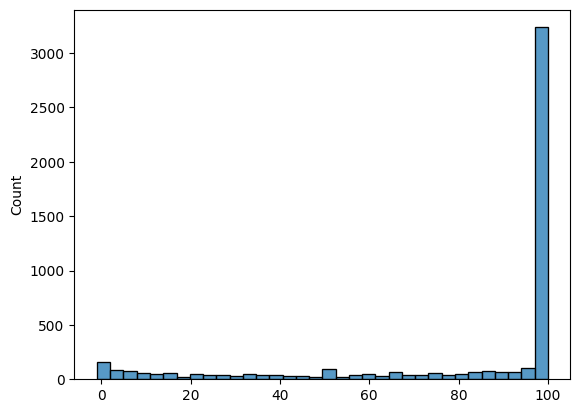

In [57]:
def get_pct_fatalities(row):
    if row[DataSchema.ABOARD_ALL] is not np.nan and row[DataSchema.FATALITIES_ALL]is not np.nan and int(row[DataSchema.ABOARD_ALL])!=0:
        return int(row[DataSchema.FATALITIES_ALL])/int(row[DataSchema.ABOARD_ALL])*100
    return -1

all = data.apply(lambda x: get_pct_fatalities(x), axis=1)

def get_pct_fatalities_passwnger(row):
    if row[DataSchema.ABOARD_ALL] is not np.nan and row[DataSchema.FATALITIES_PASSENGERS]is not np.nan and int(row[DataSchema.ABOARD_ALL])!=0:
        return int(row[DataSchema.FATALITIES_PASSENGERS])/int(row[DataSchema.ABOARD_ALL])*100
    return -1

passengers = data.apply(lambda x: get_pct_fatalities(x), axis=1)

def get_pct_fatalities_passwnger(row):
    if row[DataSchema.ABOARD_ALL] is not np.nan and row[DataSchema.FATALITIES_PASSENGERS]is not np.nan and int(row[DataSchema.ABOARD_ALL])!=0:
        return (int(row[DataSchema.FATALITIES_ALL])-int(row[DataSchema.FATALITIES_PASSENGERS]))/int(row[DataSchema.ABOARD_ALL])*100
    return -1

crew = data.apply(lambda x: get_pct_fatalities(x), axis=1)

sns.histplot(all)

In [58]:
redundant_columns.append(DataSchema.GROUND)

## Registration

In [59]:
get_pct_missing_and_unique(DataSchema.REGISTRATION, "Registration")

Registration:
False    4753
True      275
Name: count, dtype: int64
Registration field has 5.47% missing values
Registration field has 93.81% unique values


In [60]:
data[DataSchema.REGISTRATION].sample(5)

3648    CCCP-47751
143         NC1682
263          N81PF
732         G-AEUH
4894        D2-EHD
Name: Registration:, dtype: object

In [61]:
redundant_columns.append(DataSchema.REGISTRATION)

## Summary

In [62]:
get_pct_missing_and_unique(DataSchema.SUMMARY, "Summary")

Summary:
False    4969
True       59
Name: count, dtype: int64
Summary field has 1.17% missing values
Summary field has 96.96% unique values


In [63]:
data[DataSchema.SUMMARY]

0        Disappeared while en route. Plane never located.
1                                                     NaN
2                                                     NaN
3             A passenger died of cholera while en route.
4                                              Shot down.
                              ...                        
5023    Crashed while attempting to land in poor visib...
5024    The aircraft crashed into foothills during lan...
5025    While taking off, the tail of the plane struck...
5026    While landing, the aircraft scraped the runway...
5027    The aircraft crashed into the sea while en rou...
Name: Summary:, Length: 5028, dtype: object

In [65]:
# import nltk

# test = "Disappeared while en route. Plane never located."
# tokens = nltk.word_tokenize(test)
# tokens

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


: 

: 